# Boundary to field inference with (and without) hypernetworks

We are studying the propagation of uncertainty from boundary conditions to (magnetic) field solutions within that boundary. As a starting point for our baseline, we are going to degrade the problem in three ways: i) we will study solutions from exact boundaries; ii) we will use the potential rather than the field; and iii) we will use of a circular (vs. square) boundary.

Of these, the last seems unimportant. Because our observations will be of the field, we will need to work back to a method that uses that rather than the potential, some other time. But propagation of uncertainly will have to be dealt with today.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

## Example of potential and field contribution from boundary modes ('sources')

Our first insight is that, by definition, the scalar-valued potential on the boundary must be smooth*, real-valued and periodic (i.e. because it is a boundary).

*Here, smooth is to be understood as at least continuous, however unless some part of the boundary crosses the edge of a source it will be smooth in a stronger sense of continuously differentiable ($C^\infty$?) that we will use here.

Functions with these properties are expressible through a _discrete_ Fourier spectrum. Mapping the boundary (at normalised $r=1$) to the interval $\theta\in[0, 2\pi)$, we can write $$\phi(\theta) = \sum_{n=0}^\infty a_n \cos(n\theta) + b_n\sin(n\theta).$$ Moreover, when the boundary is a circle the solution (to the Laplace equation) inside the boundary is $$\phi(r, \theta) = \sum_{n=0}^\infty r^n \left[a_n \cos(n\theta) + b_n\sin(n\theta)\right].$$

This gives us a fast analytical generative recipe for studying boundary solutions: i) given a boundary function $f$, compute its discrete spectrum $(a_n, b_n)$ up to some order $n_\text{max}$; ii) generate the interior solutions to the Laplace equation as above. 

So let's do that now, picking the coefficients $(a_n, b_n)$ at random. In particular, we're going to vectorise over the modes (each value of $n$). Here's an example plot of a single mode on the boundary 'unwrapped' into the interval $[0, 2\pi)$:

In [2]:
def sph(x, y):
    return jnp.sqrt(x**2 + y**2), jnp.arctan2(y, x)


def cart(R, theta):
    return R * jnp.cos(theta), R * jnp.sin(theta)


def mode(n, r, theta):
    return jnp.stack([jnp.cos(n * theta) * r**n, jnp.sin(n * theta) * r**n])


@jax.jit
def potential(coeffs, p):
    r, theta = sph(*p)
    ks = jnp.arange(0, coeffs.size // 2)
    modes = jax.vmap(mode, (0, None, None))(ks, r, theta)
    return jnp.tensordot(modes, coeffs.T, axes=2)


@jax.jit
def field(coeffs, p):
    return jax.grad(potential, argnums=1)(-coeffs, p)


total_potential = jax.vmap(potential, (None, 0))
total_field = jax.vmap(field, (None, 0))

In [3]:
n_modes = 1
res = 200
coeffs = jnp.array([0 for _ in range(7)] + [1.0])  # n = 7 mode only
coeffs = jnp.stack([coeffs, coeffs])
theta = jnp.linspace(-jnp.pi, jnp.pi, res)

dx, dy = cart(R=1, theta=theta)
dpts = jnp.stack([dx, dy], axis=-1)
dz = total_potential(coeffs, dpts)

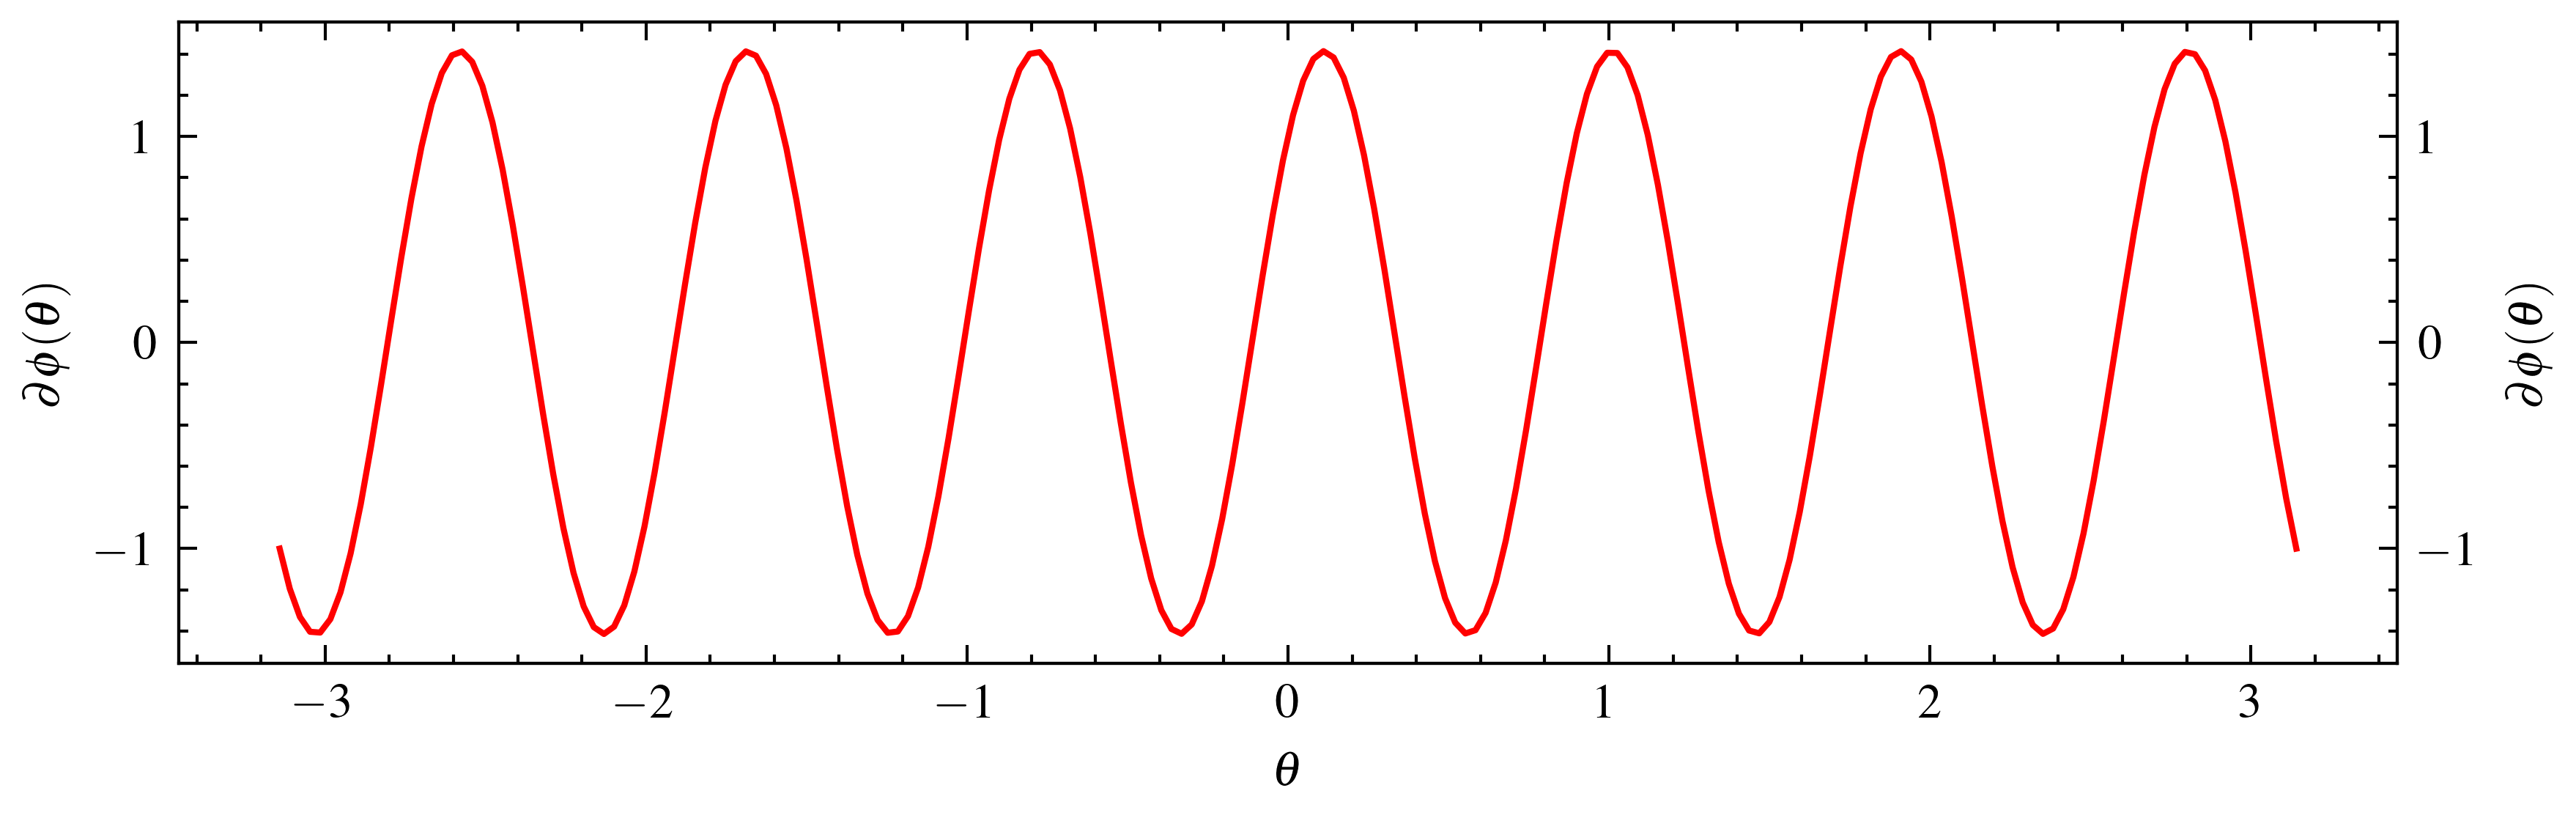

In [4]:
with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 2))

    # Left subplot: 3D line plot
    # ax1 = fig.add_subplot(121, projection="3d")
    # ax1.plot(dx, dy, dz)
    # ax1.set_xlabel("$x$")
    # ax1.set_ylabel("$y$")
    # ax1.set_zlabel("$\partial\phi(x,y)$")
    # ax1.set_title("Boundary potential $\partial\phi$")

    # Right subplot: 2D line plot
    ax2 = fig.add_subplot(111)
    ax2.plot(theta, dz, "r-")
    ax2.set_xlabel("$\\theta$")
    ax2.set_ylabel("$\partial\phi(\\theta)$")
    # ax2.set_title("Unwrapped boundary potential $\partial\phi$")
    ax3 = ax2.twinx()
    ax3.set_ylabel("$\partial\phi(\\theta)$")
    ax3.set_ylim(ax2.get_ylim())

    plt.tight_layout()
    plt.show()

Now let's immediately work with a general boundary, generating the interior potential solution and the resulting field:

In [5]:
n_modes = 15  # n_coeffs = 2*n_modes + 1
coeffs = jr.normal(shape=(2, n_modes), key=jr.PRNGKey(res)).at[1, 0].set(0.0)
dphi = total_potential(coeffs, dpts)

x, y = jnp.meshgrid(jnp.linspace(-1, 1, res), jnp.linspace(-1, 1, res))
pts = jnp.stack([x, y], axis=-1).reshape(-1, 2)
phi = total_potential(coeffs, pts).reshape(res, res)
Bx, By = total_field(coeffs, pts).reshape(res, res, 2).transpose(2, 0, 1)

x, y, phi, Bx, By = np.array(x), np.array(y), np.array(phi), np.array(Bx), np.array(By)

In [6]:
class Arrow3D(FancyArrowPatch):  # Adds streamplots projections in 3D
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)


def add_arrow_to_line3D(axes, line, arrow_locs=[0.5], arrowstyle="-|>", arrowsize=1.0):
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
        "linewidth": line.get_linewidth(),
        "color": line.get_color(),
    }

    transform = axes.transData

    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n], -2 * h)
        arrow_head = (np.mean(x[n : n + 2]), np.mean(y[n : n + 2]), -2 * h)
        pos = list(zip(arrow_tail, arrow_head))
        p = Arrow3D(*pos, transform=transform, **arrow_kw)
        if arrow_head[0] ** 2 + arrow_head[1] ** 2 < 1:
            axes.add_artist(p)

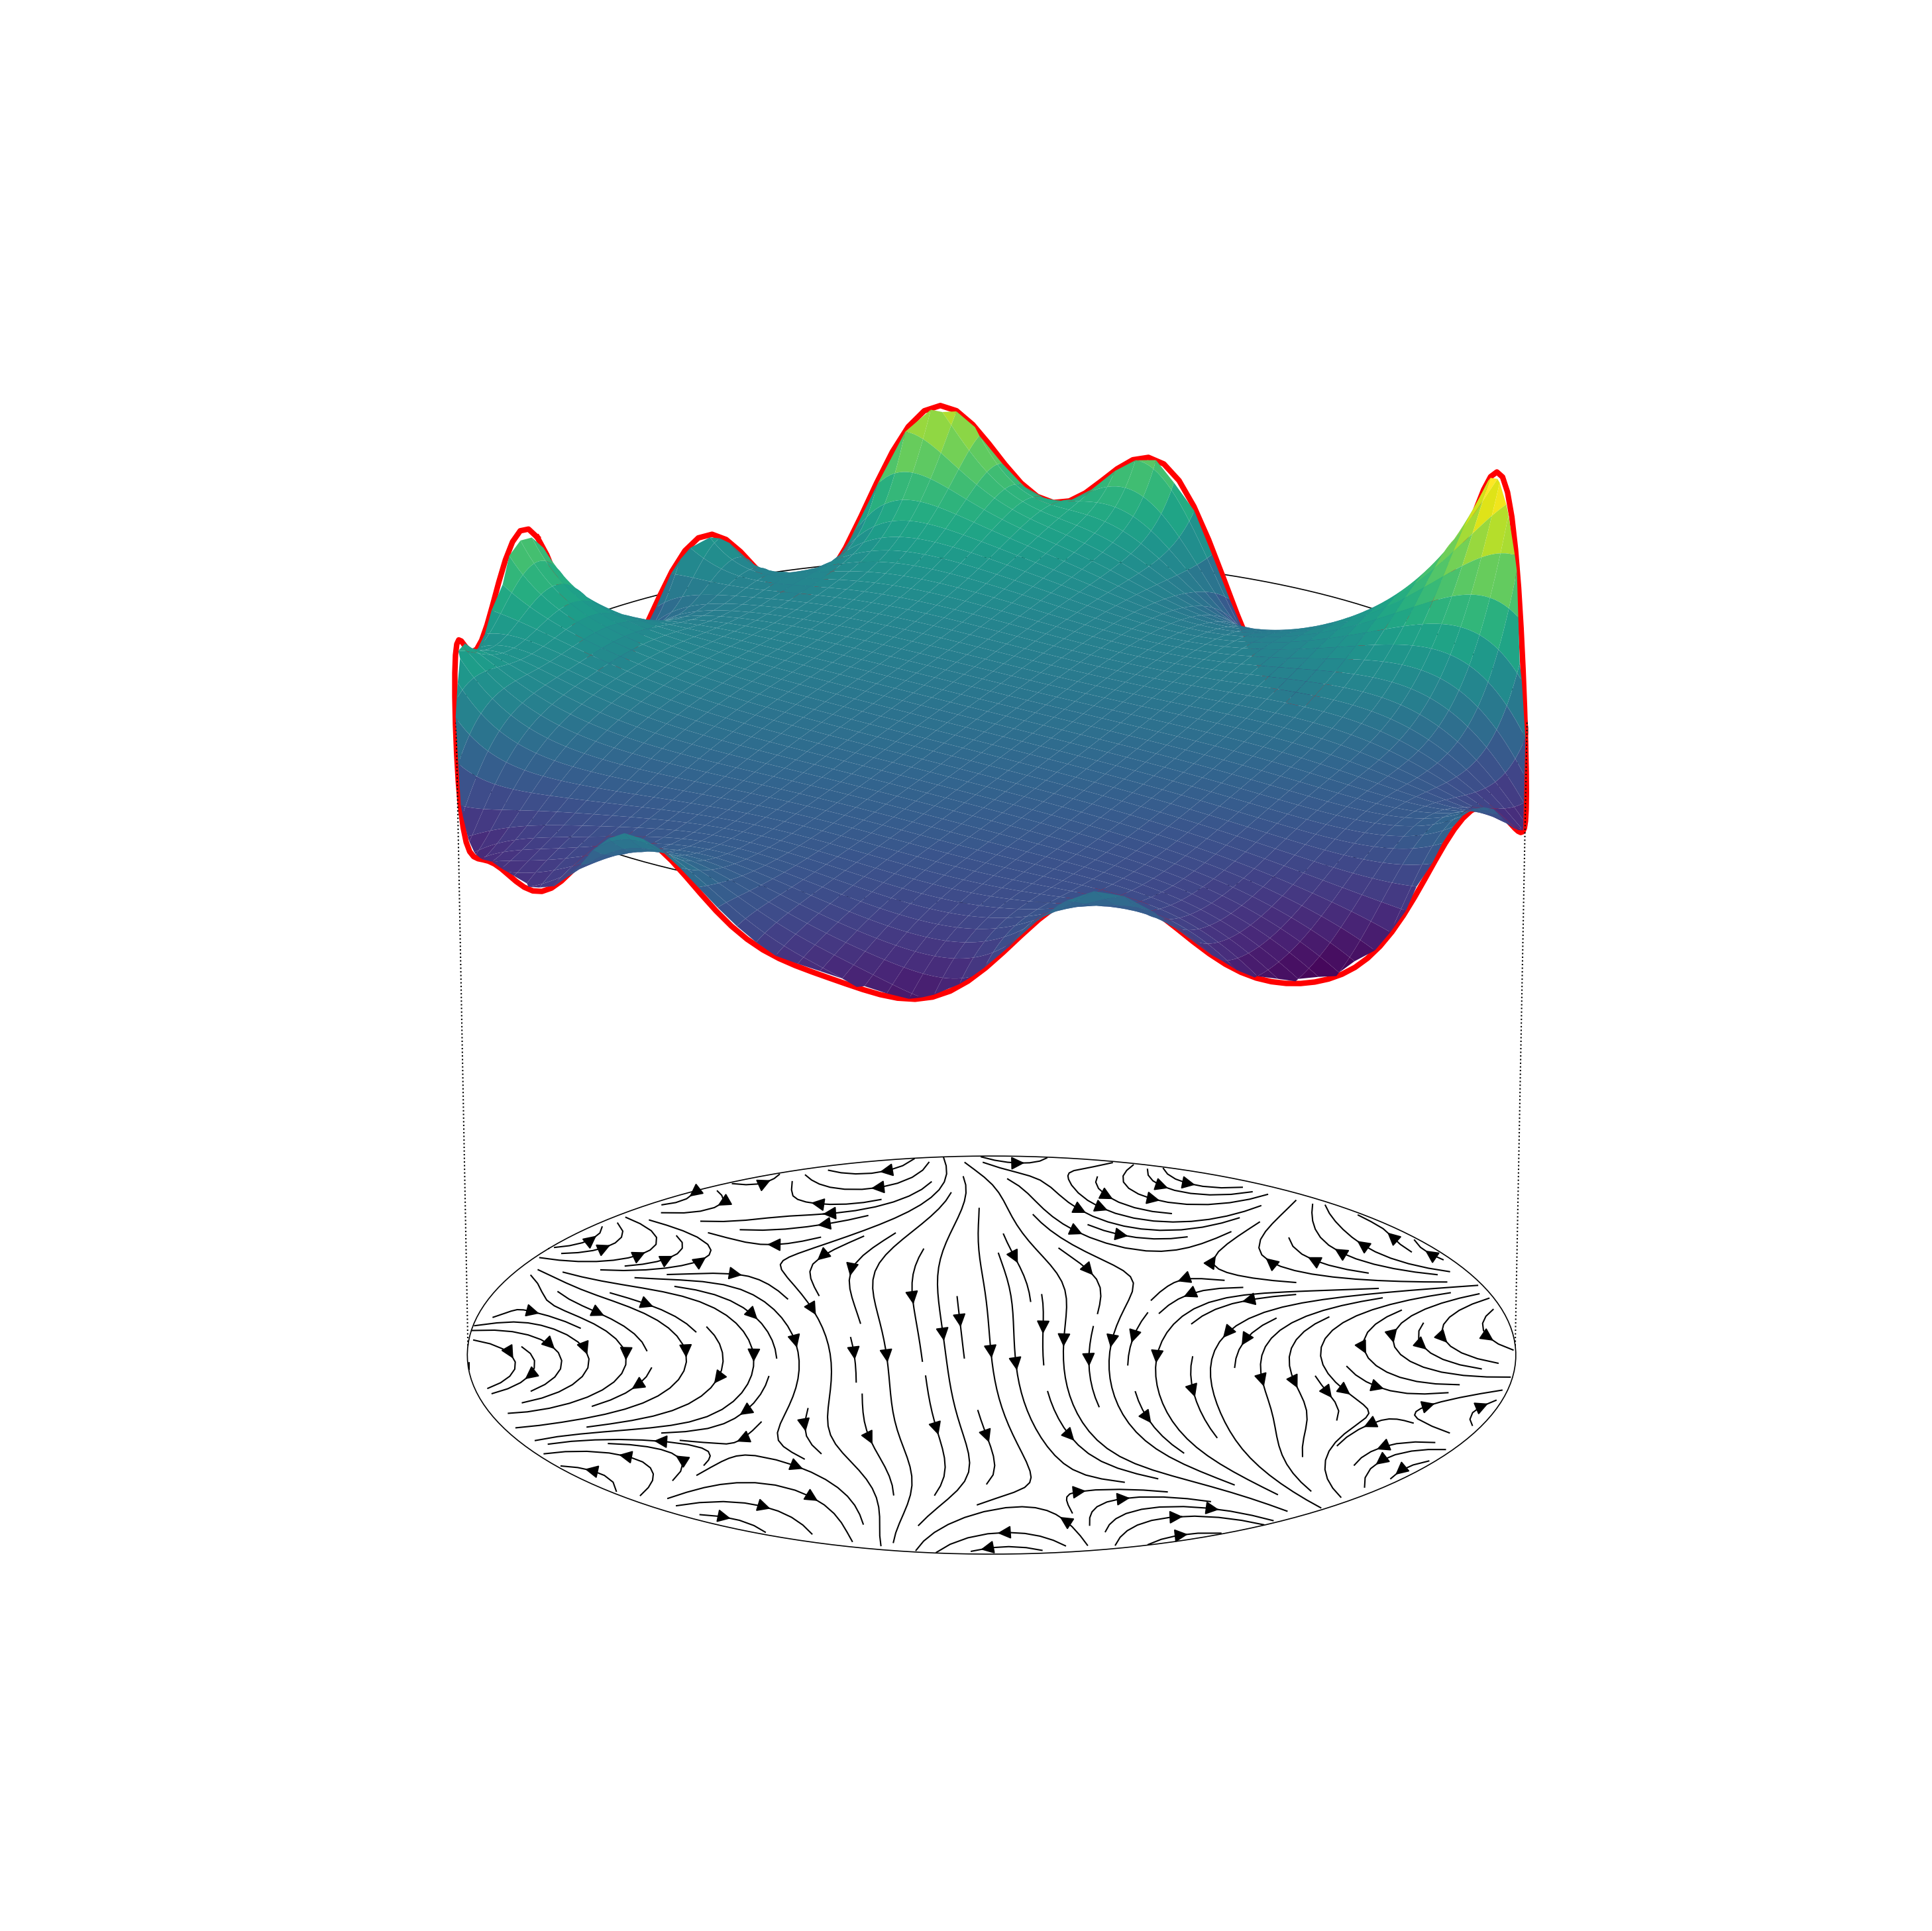

In [7]:
h = float(dphi.max() - dphi.min())

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection="3d")

    # Prevent surface cells outside the radius from being plotted
    phi[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
    ax.plot_surface(x, y, phi, cmap="viridis", edgecolor="none")
    ax.axis("off")  # Hide the background 3D axis lines

    # Plot the reference circle at r = 1
    ax.plot(dx, dy, np.zeros_like(dx), "k-", linewidth=0.2)
    ax.plot(dx, dy, np.zeros_like(dx) - 2 * h, "k-", linewidth=0.2)

    # Plot the Dircihlet boundary condition
    ax.plot(dx, dy, dphi, "r-", linewidth=1)

    fig2, ax2 = plt.subplots()  # Temporary subplot for streamplot calculation
    stream = plt.streamplot(x, y, Bx, By, density=1.5)

    # Extract streamline paths and plot them in 3D
    for path in stream.lines.get_paths():
        v = path.vertices
        vx, vy = v[:, 0], v[:, 1]
        hp = np.zeros_like(vx) - 2 * h
        hp[vx**2 + vy**2 >= 1.0] = np.nan
        line = ax.plot3D(vx, vy, hp, "k-", linewidth=0.25)
        add_arrow_to_line3D(ax, line[0], arrow_locs=[0.5], arrowsize=0.5)

    # Plot dashed guidelines from boundary circle down to xy-plane
    t = np.pi / 2 - np.pi / 3
    xd, yd = np.cos(t), np.sin(t)
    ax.plot([xd, xd], [yd, yd], [-2 * h, 0.0], "k:", linewidth=0.25)
    ax.plot([-xd, -xd], [-yd, -yd], [-2 * h, 0.0], "k:", linewidth=0.25)

    plt.close(fig2)  # Close the temporary figure

    ax.view_init(elev=20.0)

    plt.tight_layout()
    plt.show()

(N.b. gaps at the edges between the boundary function (in red) and the interior solution surface are discretisation artefacts, not approximation error. Our solution is an exact generative model for all $(x,y)$ within the boundary and the mesh is simply for visualisation.)

## Periodic gaussian process for boundary data observations

Returning to our boundary condition $\partial\phi(\theta)\equiv f$, we now want to construct sampling process that generates complete boundaries from observed data. 

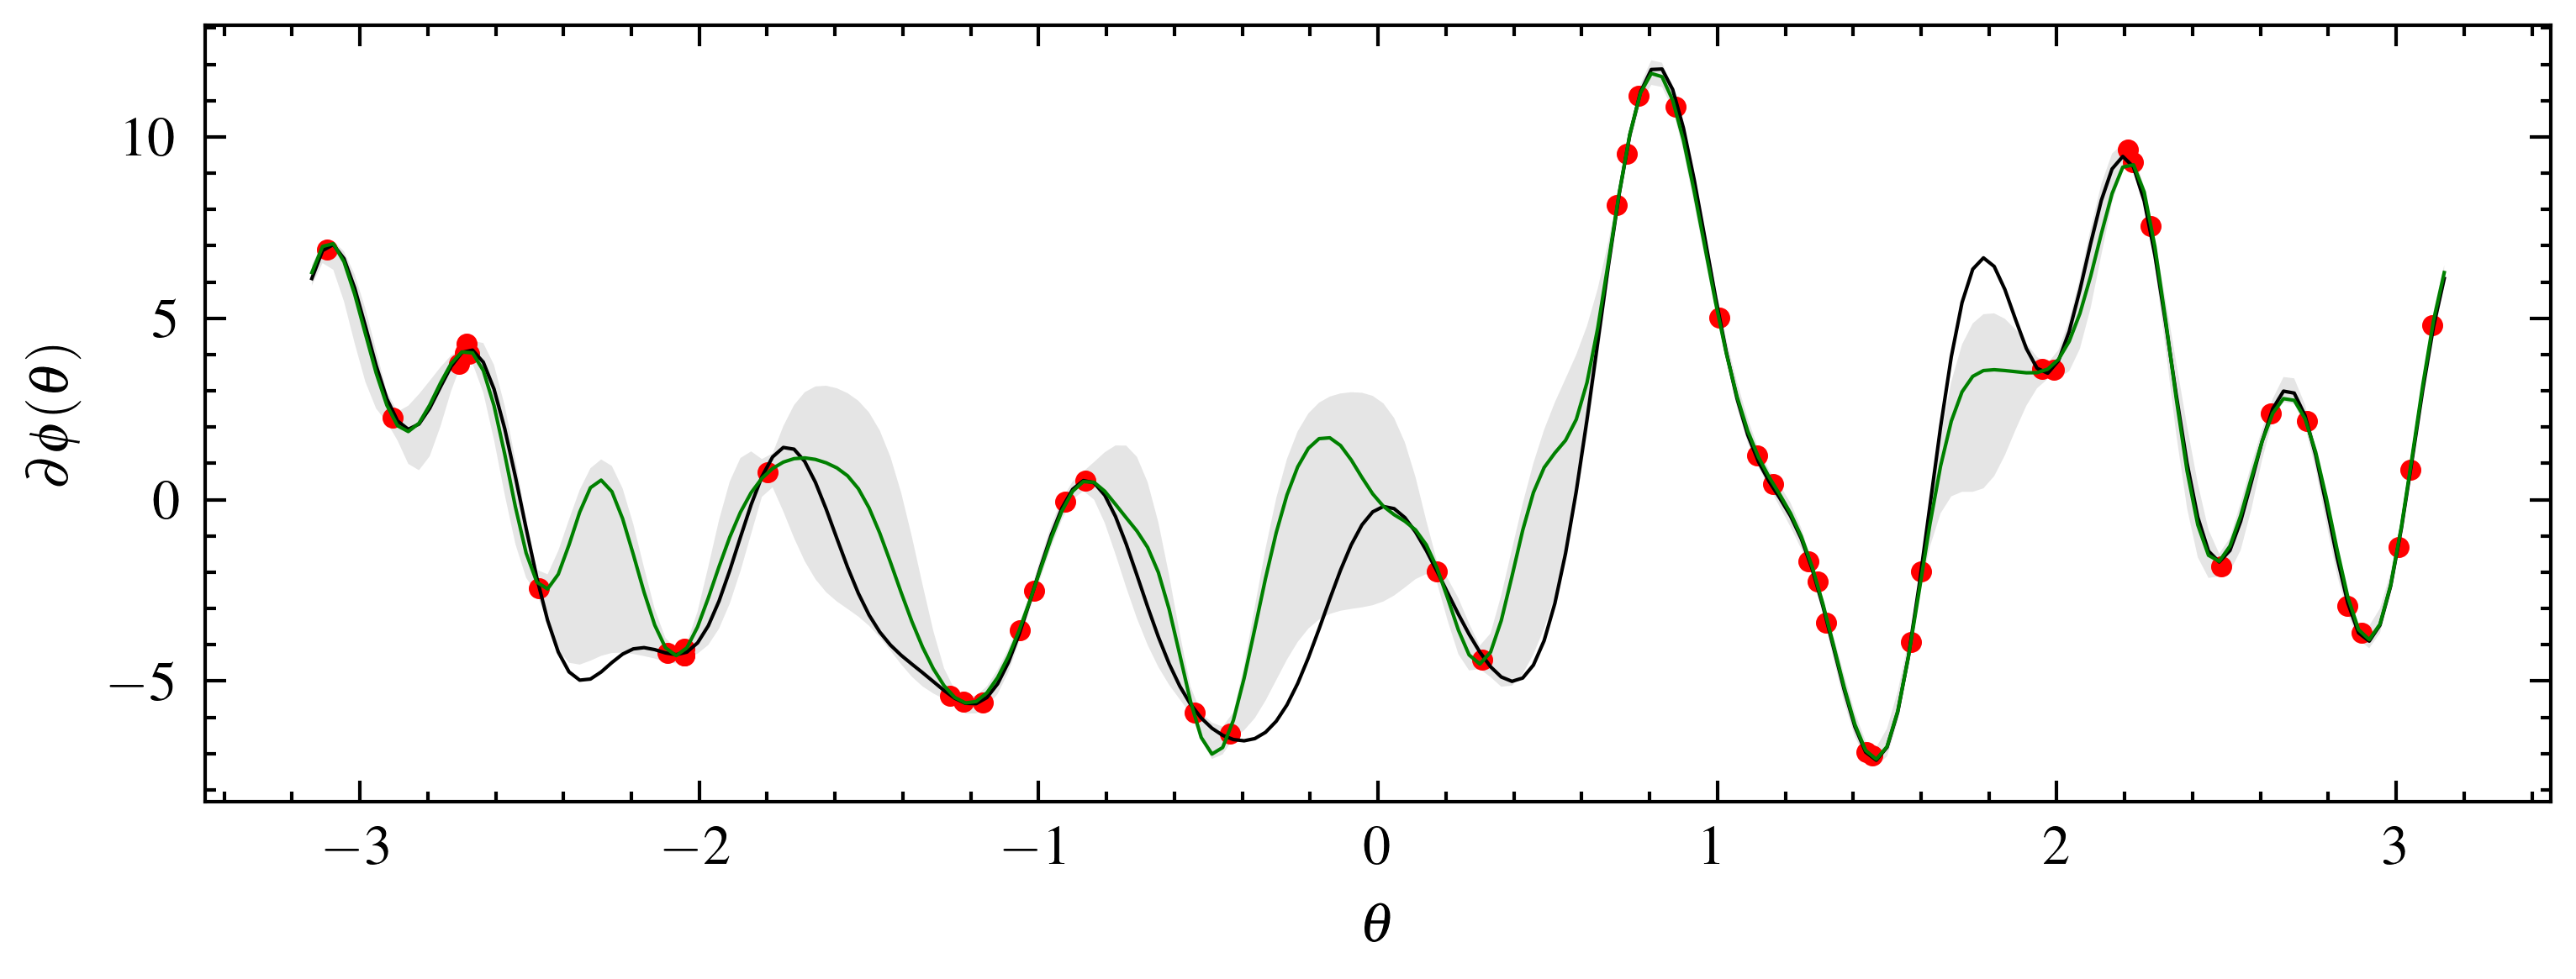

In [49]:
import time

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import ExpSineSquared as PK

N = 50
seed = int(time.time())
theta_obs = jr.uniform(key=jr.PRNGKey(seed), shape=(N,)).sort() * 2 * jnp.pi - jnp.pi
pts_obs = cart(1.0, theta_obs)
dphi_obs = (
    total_potential(coeffs, pts_obs)
    + jr.normal(key=jr.PRNGKey(seed + 1), shape=(N,)) * 0.1
)
X, Y = theta_obs.reshape(-1, 1), dphi_obs.reshape(-1, 1)
dBx_obs, dBy_obs = total_field(coeffs, pts_obs)
dB_obs = (
    jnp.stack([dBx_obs, dBy_obs])
    # + jr.normal(key=jr.PRNGKey(seed + 2), shape=(2, N)) * 0.1
)

kernel = PK(length_scale=1, periodicity=2 * np.pi, periodicity_bounds="fixed")
gpr = GPR(kernel=kernel, alpha=0.01, n_restarts_optimizer=9).fit(X, Y)
mean_prediction, std_prediction = gpr.predict(theta.reshape(-1, 1), return_std=True)
samples = gpr.sample_y(theta.reshape(-1, 1), n_samples=200)
sample = samples[:, 0].ravel()

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(theta_obs, dphi_obs, "ro", markersize=2)
    plt.plot(theta, dphi, color="black", linewidth=0.5)
    plt.plot(theta, sample, "g-", linewidth=0.5)
    plt.fill_between(
        theta.ravel(),
        mean_prediction - 3 * std_prediction,
        mean_prediction + 3 * std_prediction,
        alpha=0.1,
        label=r"95% confidence interval",
    )

    plt.xlabel("$\\theta$")
    plt.ylabel("$\partial\phi(\\theta)$")
    plt.show()

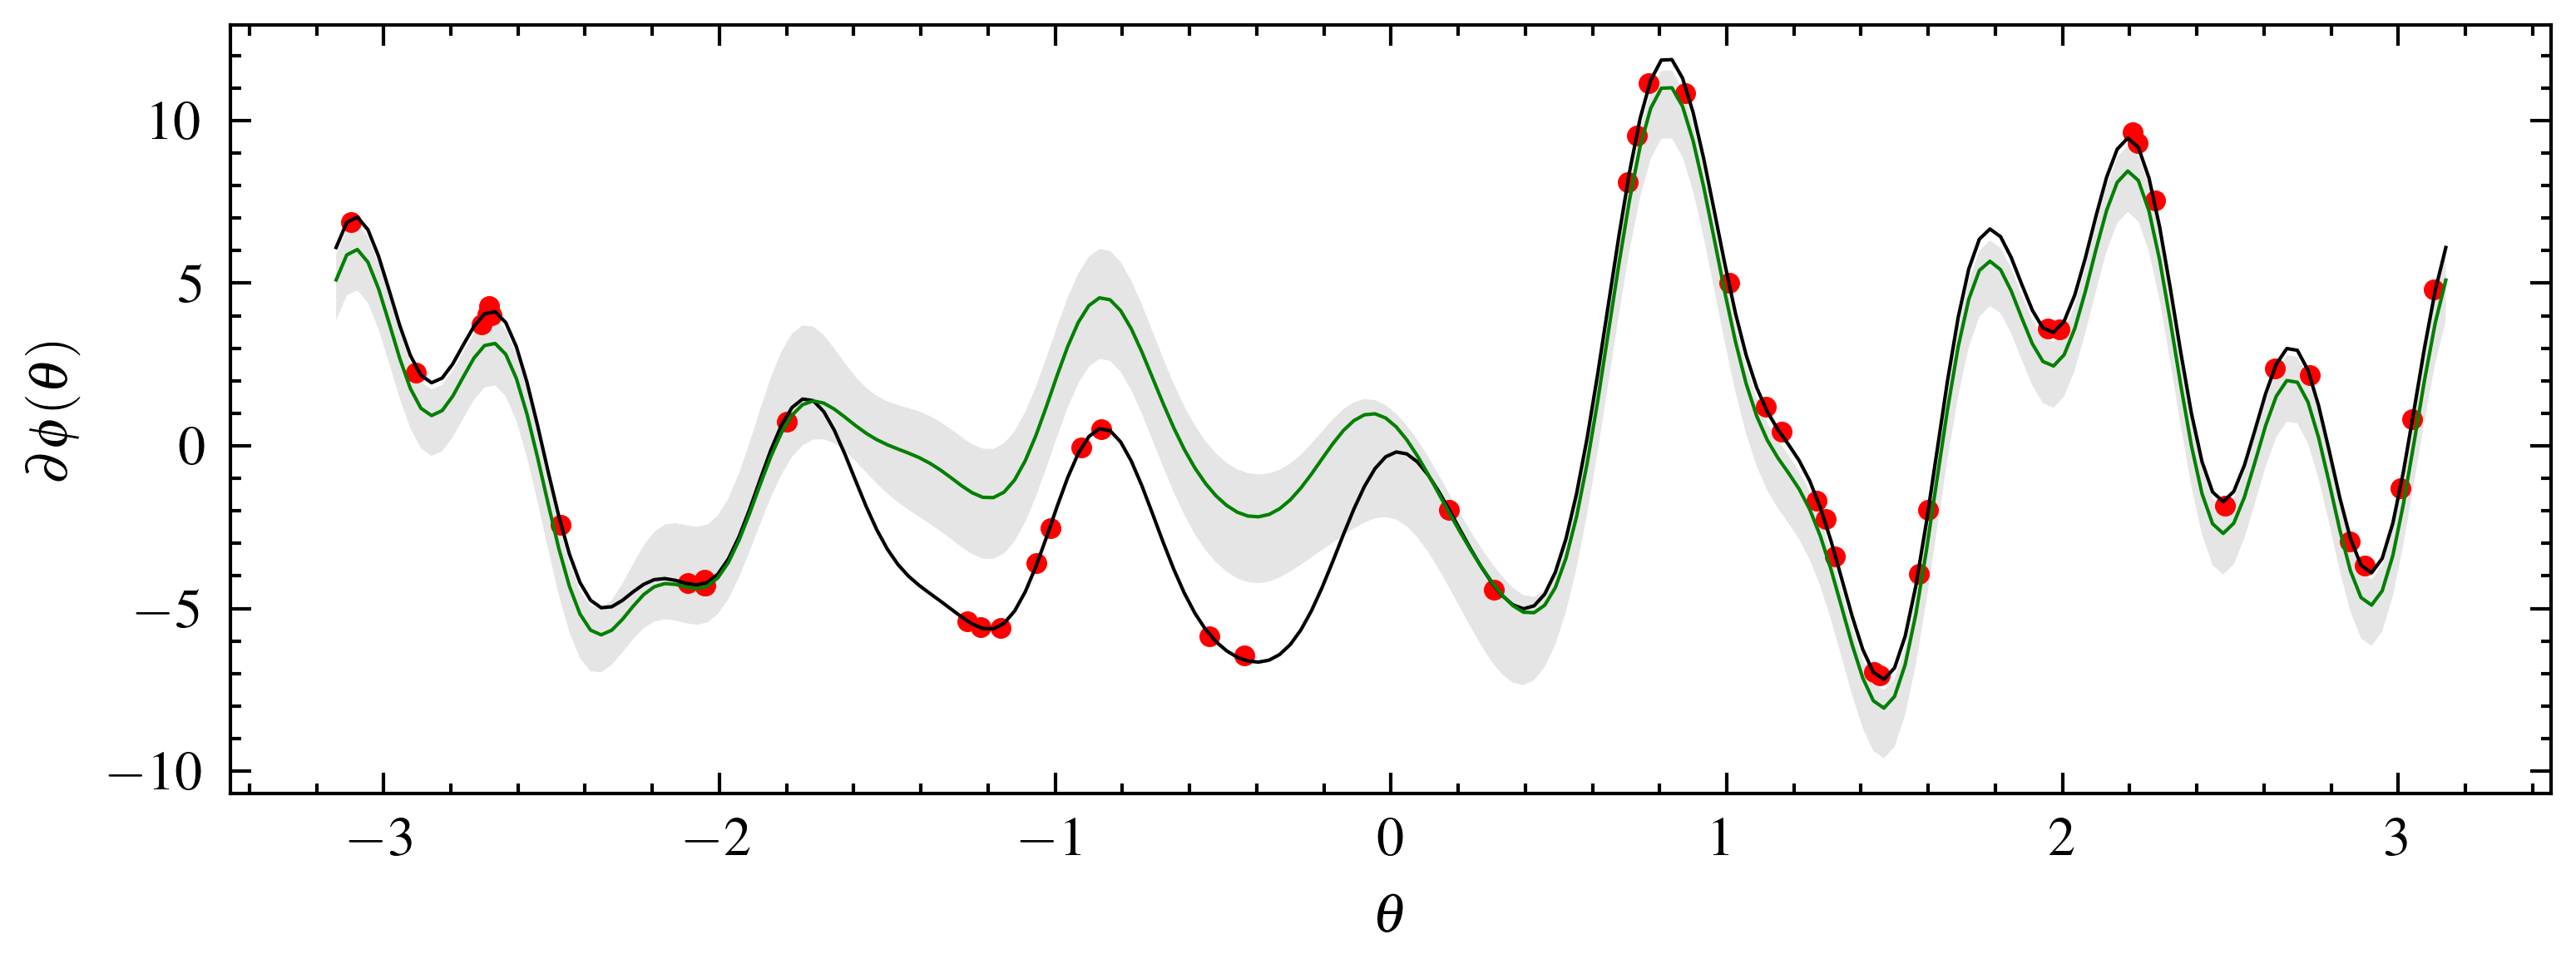

In [50]:
from dgp import kernels, regression

kernel = kernels.ess(lengthscale=0.2, variance=1.0)
X = jnp.array([*pts_obs]).T
Xs = jnp.array([*cart(1.0, theta)]).T

gp = regression.fit(X, dB_obs.T, kernel)
mean_prediction, cov = regression.predict(Xs, gp)
std_prediction = jnp.sqrt(jnp.diag(cov))
offset = mean_prediction.mean()
mean_prediction -= offset
mean_prediction = mean_prediction.squeeze()


def sample_y(seed: int):
    return jr.multivariate_normal(jr.PRNGKey(seed), mean_prediction, cov, method="svd")


sample = sample_y(seed=int(time.time()))

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(theta_obs, dphi_obs, "ro", markersize=2)
    plt.plot(theta, dphi, color="black", linewidth=0.5)
    # plt.plot(theta, mean_prediction, "g--", linewidth=0.5)
    plt.plot(theta, sample, "g-", linewidth=0.5)
    plt.fill_between(
        theta.ravel(),
        mean_prediction - 3 * std_prediction,
        mean_prediction + 3 * std_prediction,
        alpha=0.1,
        label=r"95% confidence interval",
    )

    plt.xlabel("$\\theta$")
    plt.ylabel("$\partial\phi(\\theta)$")
    plt.show()

In [51]:
samples = jax.vmap(sample_y)(jnp.array(range(100))).T

In [52]:
def _decompose(sample):
    n_max = sample.shape[0] // 2 + 1
    F = jnp.fft.rfft(sample) / sample.shape[0]

    # Preparing coefficients
    a_n = 2 * jnp.real(F[:n_max])
    b_n = -2 * jnp.imag(F[:n_max])

    # Adjust DC component
    a_n = a_n.at[0].set(a_n[0] / 2)

    # Adjust sign for odd indexed coefficients, if necessary
    index_odd = jnp.arange(1, n_max, 2)
    a_n = a_n.at[index_odd].multiply(-1)
    b_n = b_n.at[index_odd].multiply(-1)

    # Correctly handle the Nyquist frequency, if N is even
    if sample.shape[0] % 2 == 0:
        a_n = a_n.at[-1].set(F[-1].real / sample.shape[0])

    return jnp.stack([a_n, b_n], axis=0)


decompose = jax.jit(_decompose, device=jax.devices("cpu")[0])

In [53]:
sample_coeffs = jax.vmap(decompose, 1)(jnp.array(samples))
sample_dphi = jax.vmap(total_potential, (0, None))(sample_coeffs, dpts)
sample_phi = jax.vmap(total_potential, (0, None))(sample_coeffs, pts).reshape(
    -1, res, res
)

In [54]:
sample_field = jax.vmap(total_field, (0, None))(sample_coeffs, pts)
sample_field_mean = np.array(sample_field.mean(axis=0))
sample_field_std = np.array(sample_field.std(axis=0))

# sample_field_std /= sample_field_mean

mBx, mBy = sample_field_mean.reshape(res, res, 2).transpose(2, 0, 1)
sBx, sBy = sample_field_std.reshape(res, res, 2).transpose(2, 0, 1)

mBx[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
mBy[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
# sBx[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
# sBy[np.sqrt(x**2 + y**2) >= 1.0] = np.nan

In [55]:
dx_obs, dy_obs = cart(R=1, theta=theta_obs)
dpts_obs = jnp.stack([dx_obs, dy_obs], axis=-1)

In [56]:
mphi = np.array(sample_phi.mean(axis=0))
stdphi = np.array(sample_phi.std(axis=0))
mdphi = np.array(sample_dphi.mean(axis=0))
stddphi = np.array(sample_dphi.std(axis=0))

mphi[np.sqrt(x**2 + y**2) >= 1.0] = np.nan
stdphi[np.sqrt(x**2 + y**2) >= 1.0] = np.nan

# stdphi /= mphi

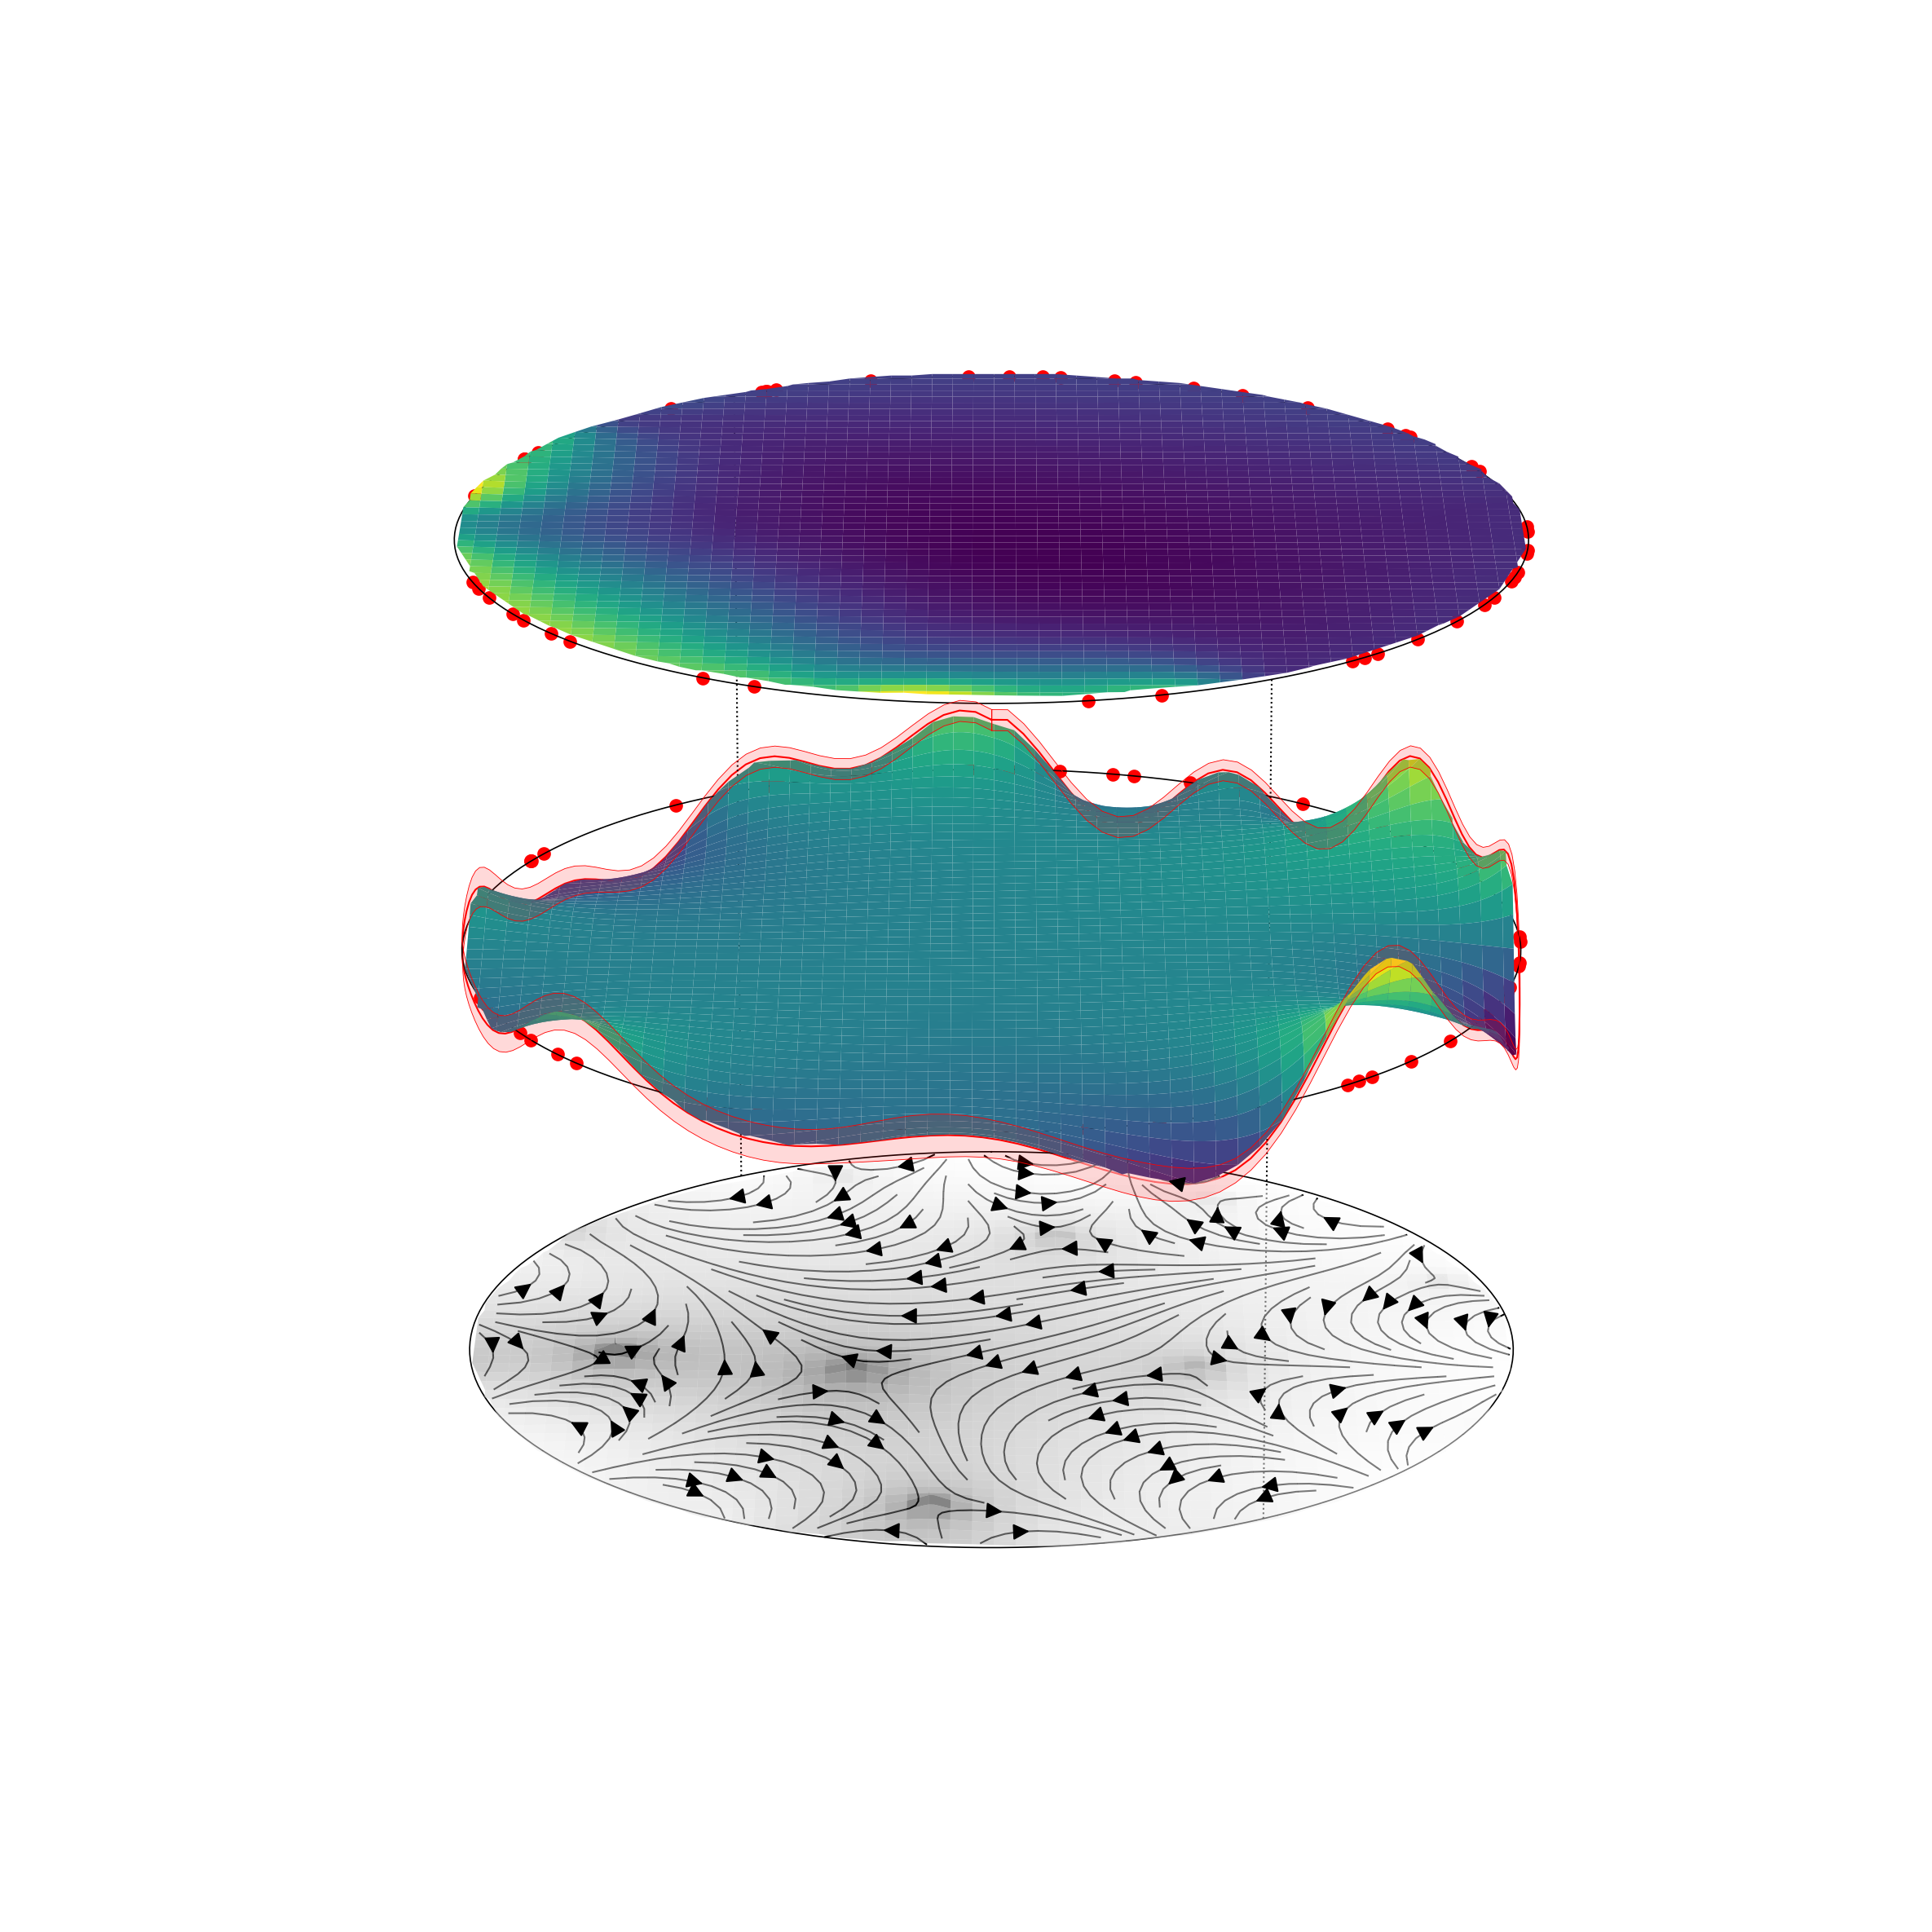

In [57]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    # Prevent surface cells outside the radius from being plotted

    # Plot the Dircihlet boundary condition
    ax.plot(dx, dy, mdphi, "r-", linewidth=0.25)

    above = [
        (dx[i].item(), dy[i].item(), mdphi[i] + 3 * stddphi[i]) for i in range(len(dx))
    ]
    below = [
        (dx[i].item(), dy[i].item(), mdphi[i] - 3 * stddphi[i]) for i in range(len(dx))
    ]
    verts = above + list(reversed(below))

    ax.add_collection3d(
        Poly3DCollection(
            [verts], linewidth=0.1, edgecolor="none", color="red", alpha=0.15
        )
    )

    ax.plot_surface(x, y, mphi, cmap="viridis", edgecolor="none")
    ax.axis("off")  # Hide the background 3D axis lines

    ax.plot_surface(x, y, stdphi + 2 * h, cmap="viridis", edgecolor="none")
    plt.plot(dx_obs, dy_obs, 2 * h, "ro", markersize=1)

    # Plot the observed points
    plt.plot(dx_obs, dy_obs, 0, "ro", markersize=1)

    # Plot the reference circles at r = 1
    ax.plot(dx, dy, np.zeros_like(dx), "k-", linewidth=0.2)
    ax.plot(dx, dy, np.zeros_like(dx) + 2 * h, "k-", linewidth=0.2)
    ax.plot(dx, dy, np.zeros_like(dx) - 2 * h, "k-", linewidth=0.2)

    fig2, ax2 = plt.subplots()  # Temporary subplot for streamplot calculation
    uncertainty = np.sqrt(sBx**2 + sBy**2) / (0.1 + np.sqrt(mBx**2 + mBy**2))
    stream = plt.streamplot(x, y, mBx, mBy, density=1.5)

    ax.plot_surface(
        x,
        y,
        np.sqrt(uncertainty) - 2.025 * h,
        cmap="binary",
        edgecolor="none",
        alpha=0.5,
    )

    # Extract streamline paths and plot them in 3D
    for path in stream.lines.get_paths():
        v = path.vertices
        vx, vy = v[:, 0], v[:, 1]
        hp = np.zeros_like(vx) - 2 * h
        hp[vx**2 + vy**2 >= 1.0] = np.nan
        line = ax.plot3D(vx, vy, hp, "k-", linewidth=0.25)
        add_arrow_to_line3D(ax, line[0], arrow_locs=[0.5], arrowsize=0.5)

    # Plot dashed guidelines from boundary circle down to xy-plane
    t = np.pi / 2 - np.pi / 3
    xd, yd = np.cos(t), np.sin(t)
    ax.plot([xd, xd], [yd, yd], [-2 * h, 0.0], "k:", linewidth=0.25)
    ax.plot([-xd, -xd], [-yd, -yd], [-2 * h, 0.0], "k:", linewidth=0.25)
    ax.plot([xd, xd], [yd, yd], [2 * h, 0.0], "k:", linewidth=0.25)
    ax.plot([-xd, -xd], [-yd, -yd], [2 * h, 0.0], "k:", linewidth=0.25)

    plt.close(fig2)  # Close the temporary figure

    ax.view_init(elev=20.0, azim=0)

    plt.show()

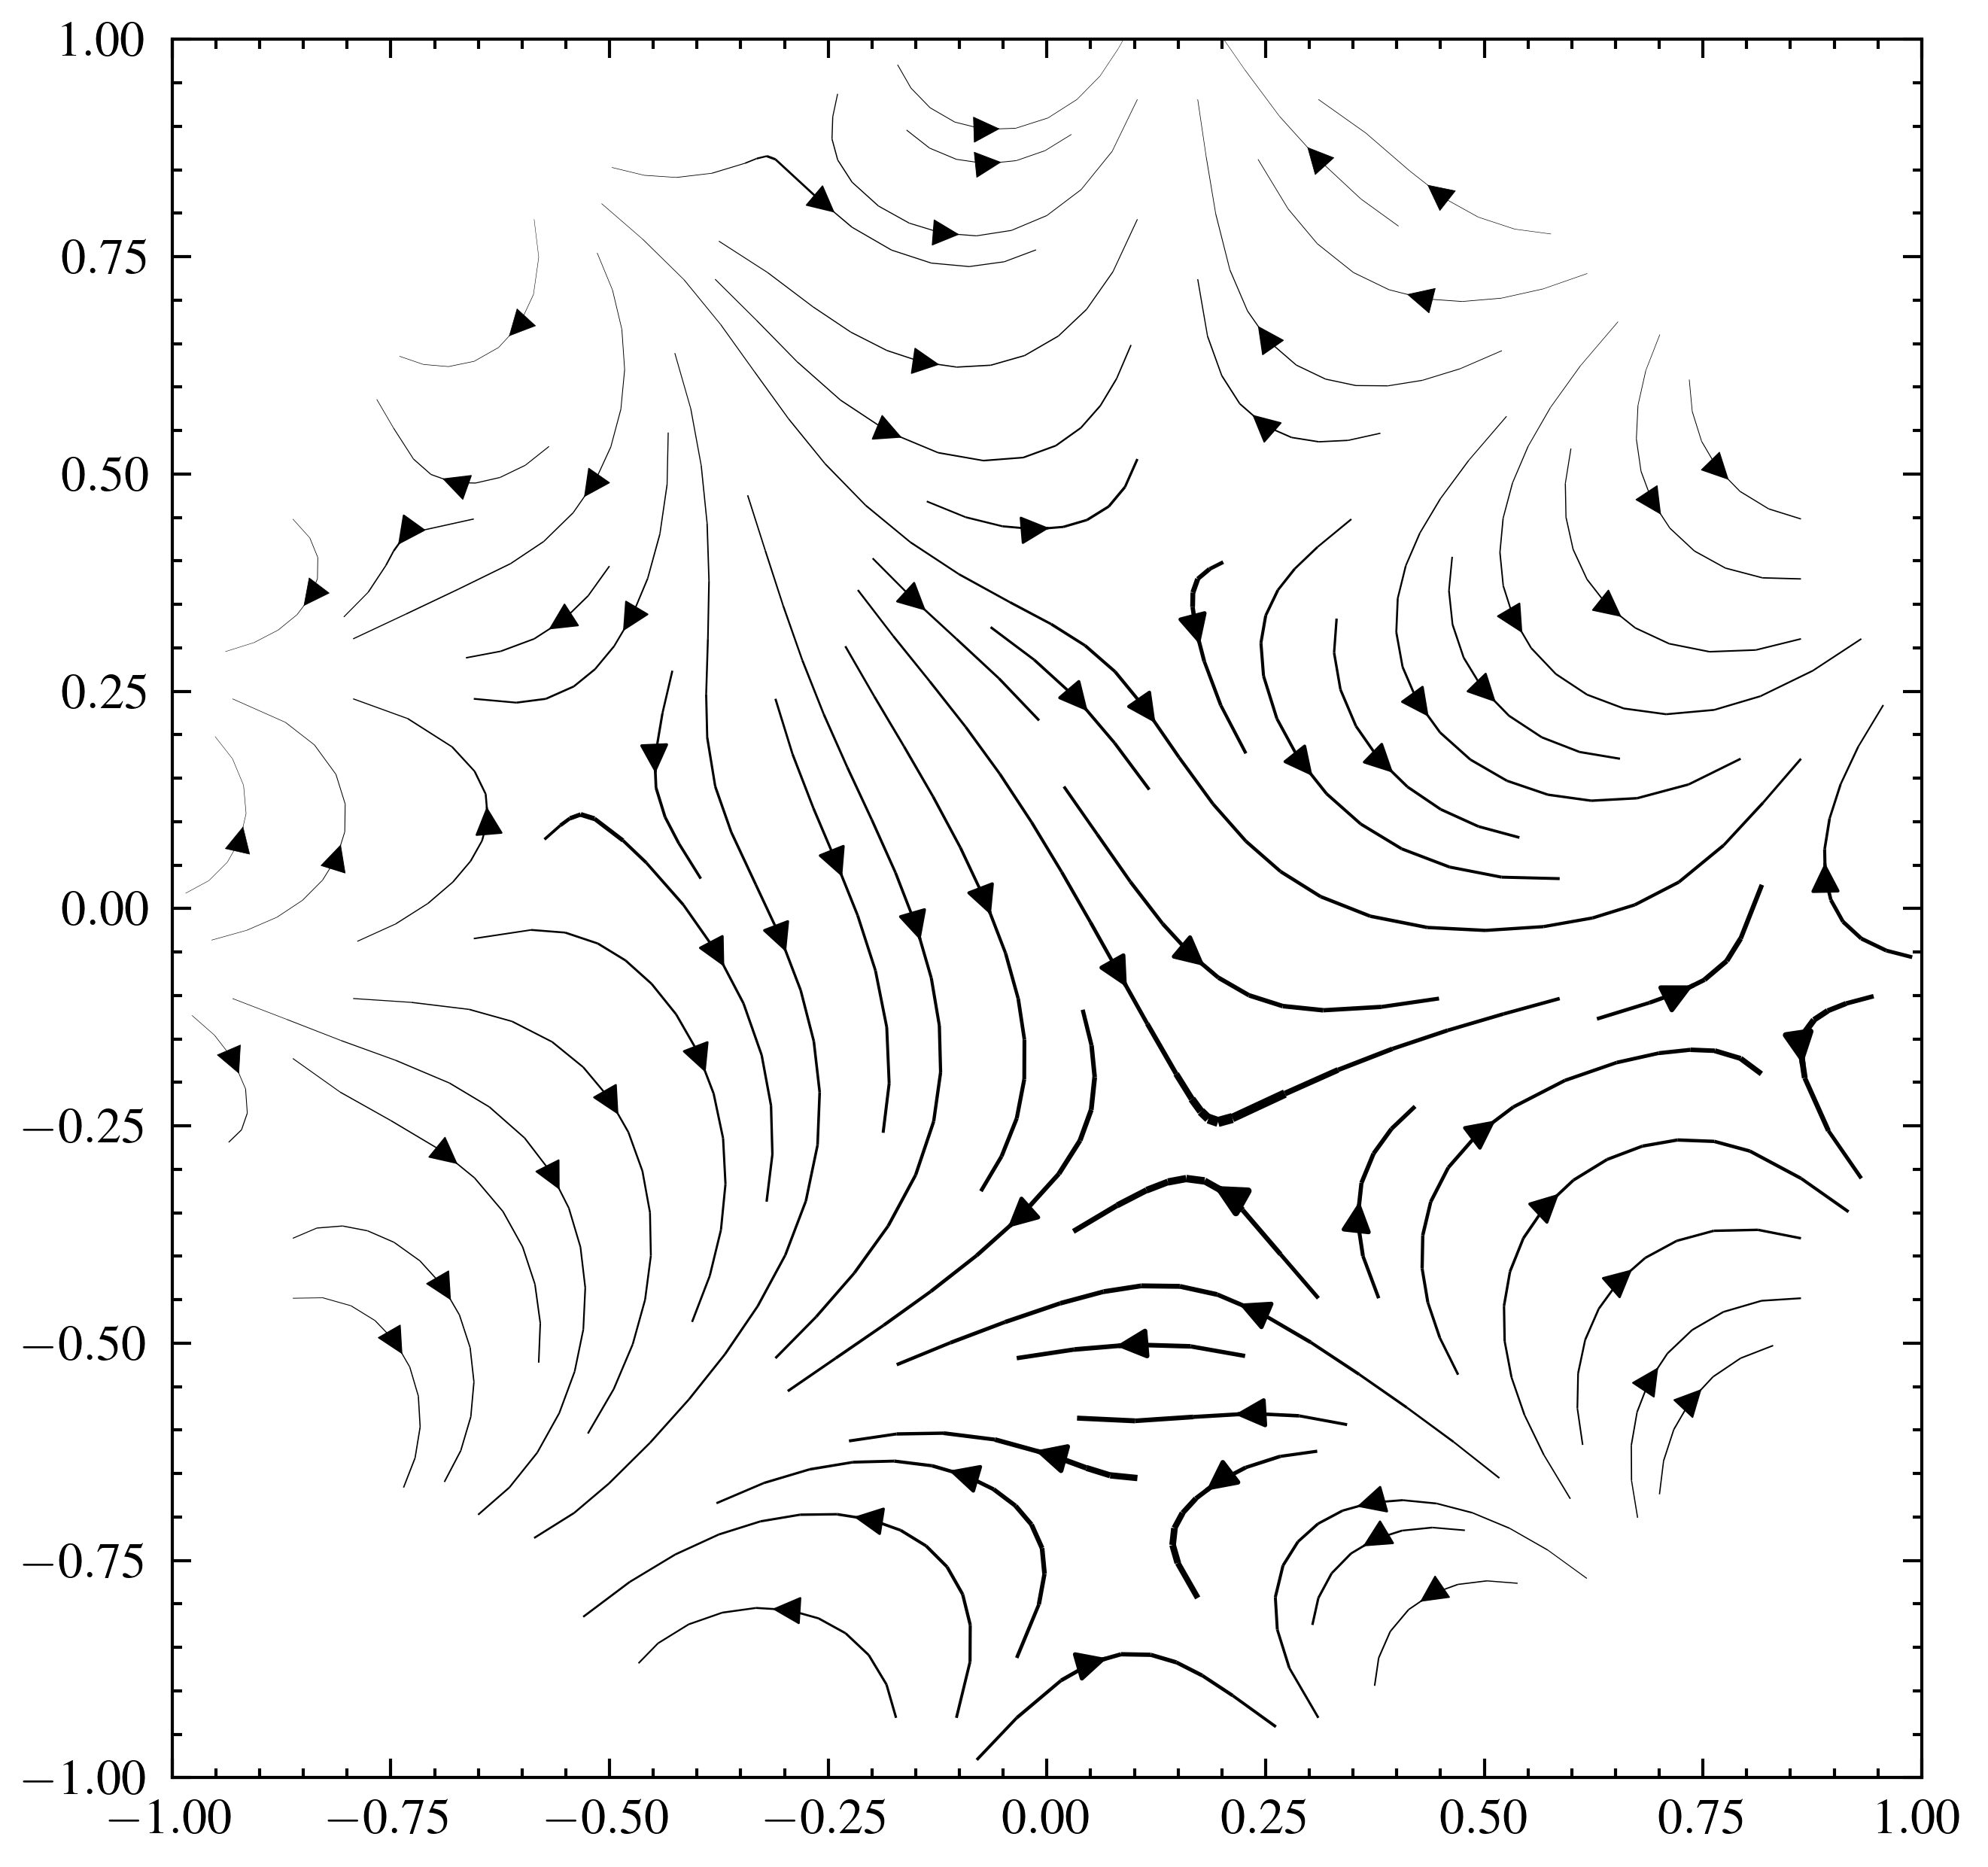

In [58]:
with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)

    stream = plt.streamplot(x, y, mBx, mBy, density=1, linewidth=np.sqrt(uncertainty))

    plt.show()

In [ ]:
with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(theta_obs, dphi_obs, "o", markersize=2)
    # plt.plot(theta, dphi, color="grey", linewidth=0.5)
    plt.plot(theta, sample, "k-", linewidth=0.5)
    plt.fill_between(
        theta.ravel(),
        mean_prediction - 3 * std_prediction,
        mean_prediction + 3 * std_prediction,
        alpha=0.1,
        label=r"95% confidence interval",
    )
    plt.plot(theta * (1 + 1.0 / res) + 2.0 / res, sample_dphi[0], "g--", linewidth=0.5)

    plt.xlabel("$\\theta$")
    plt.ylabel("$\partial\phi(\\theta)$")
    plt.show()

## An interesting correspondence enabling a fast approximate solution

The baseline implementation above is the $\mathcal{O}(N_\text{max}\times\text{res}^2)$. It is interesting to note that the interior solutions to the Laplace equation satisfy _the principle of superposition_ with regard to the individual modes on the boundary. In this sense we can make the following correspondences:
$$
\begin{align}
&\text{single $n$ boundary mode} & \leftrightarrow\ & \text{individual `source' of $\phi$} \\
&\text{boundary function $\partial\phi$} & \leftrightarrow\ & \text{source `collection' generating $\phi$} \\
&\text{Laplace solution $\nabla^2\phi = 0$} & \leftrightarrow\ & \text{potential $\phi$ generated by source collection} \\
\end{align}
$$

Having observed this, we can create a PINN that solves a given boundary potential $f$ using the methods from an exciting recent submission to ICML

<center><img src="assets/header.png" alt="Scalable source-to-field inference with hypernetworks" width="800px" /></center>

In this scheme, the PINN we develop is $\mathcal{O}(N_\text{max} + \text{res}^2)$, and $\text{---}$ unusally for a PINN $\text{---}$ provides a solution to the Laplace equation for _general_ boundary conditions without requiring retraining.

The start of this implementation is below. So far, I have just written the sampler for the training data to avoid overfitting from a grid.

In [ ]:
def sample_disc(N, seed=0):
    rkey, tkey = jr.split(jr.PRNGKey(seed))
    r = jnp.sqrt(jr.uniform(rkey, (N,)))
    theta = 2 * jnp.pi * jr.uniform(tkey, (N,))
    return cart(r, theta)


x, y = sample_disc(2000, seed=20)

with plt.style.context(["science", "ieee"]):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(x, y, color="black", s=1, alpha=0.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("Training abscissa within boundary")
    plt.show()